# Step : Initialize Core Modules

In [1]:
import sys,os#Add sys to get cmdline_helper from NRPy top directory; remove this line and next when debugged
sys.path.append('../')
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface

# Create C code output directory:
Ccodesdir = "IMR"
# Then create an output directory in case it does not exist
cmd.mkdir(Ccodesdir)

# Step : Call Initial Conditions
Note : Our new choice of calibration is to obtain $\Delta t$ from BOB at the end of the dynamics. However, if we opt to set $\Delta t$ as a free parameter, then we can feed a value directly. Since the dynamics terminate before ISCO for a positive $\Delta t$, we set the provisional $\Delta t$ for BOB as negative to ensure the dynamics is integrated to one of the ordinary termination conditions. 
LIGO approximants generally provide times in seconds. Thus, the desired sampling `dt` is scaled by the mass factor as EOB uses time in geomtrized units.

In [2]:
%%writefile $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
Deltat_init = Delta_t
if Delta_t == 'BOB':
    Deltat_init = -1
dT = dt/M/4.925490947641266978197229498498379006e-6
m1,m2,chi1,chi2,y_init,Omega_0,h_init,rstop,rISCO,af,Mf,h22NR,omega22NR = v5HM_BOB_optimized_initial_conditions(M,q,S1,S2,f,a6,dSO,Deltat_init)
omega22NR *= -1
if af > 0:
    qnm_cache = qnm.modes_cache(s = -2, l = 2, m = 2, n= 0)
    omega_complex, _, _ = qnm_cache(a = af, interp_only = True)
else:
    qnm_cache = qnm.modes_cache(s = -2, l = 2, m = -2, n= 0)
    omega_complex, _, _ = qnm_cache(a = np.abs(af), interp_only = True)

omega_complex_norm = omega_complex/Mf
omega_qnm = np.real(omega_complex_norm)
tau = -1./(np.imag(omega_complex_norm))

Overwriting IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Step : Evaluate Dynamics


In [3]:
%%writefile -a $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
dynamics_coarse, dynamics_fine = v5HM_BOB_integrator_calibration(m1,m2,chi1,chi2,y_init,Omega_0,a6,dSO,rstop,h_init)
dynamics = np.vstack((dynamics_coarse,dynamics_fine))

Appending to IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Step : Find ISCO crossing

Note : pySEOBNR puts in checks for situations where the dynamics are terminated before the perturber crosses the ISCO of the final black hole. In such a case, we choose the end point of the dynamics as the effective ISCO crossing time. (Calibration Notes: In this case, a BOB $\Delta t$ will take in inputs before ISCO. Would be worthwhile to check how accurate the waveform is in this case or if using the BOB $\Delta t$ allows us to push the integration past ISCO.)

In [4]:
%%writefile -a $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
if rISCO < dynamics_fine[-1,1]:
    t_ISCO = dynamics_fine[-1,0]
    omega_orb_ISCO = dynamics_fine[-1,6]
else:
    dt_isco = 0.001
    N = int((dynamics_fine[-1,0] - dynamics_fine[0,0]) / dt_isco)
    zoom = np.linspace(dynamics_fine[0,0],dynamics_fine[-1,0], N)
    n = len(dynamics_fine)
    intrp_r = spline.cspline(n)
    intrp_r.init(dynamics_fine[:,0], dynamics_fine[:,1])
    r_zoomed_in = intrp_r.eval_e_vector(zoom)
    intrp_omega = spline.cspline(n)
    intrp_omega.init(dynamics_fine[:,0], dynamics_fine[:,6])
    omega_zoomed_in = intrp_omega.eval_e_vector(zoom)
    idx = (np.abs(r_zoomed_in - rISCO)).argmin()
    t_ISCO = zoom[idx]
    omega_orb_ISCO = omega_zoomed_in[idx]

Appending to IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Compute t_attach

Note: pySEOBNR has checks for situations where the dynamics are terminated before the peak strain time, in which case the merger-ringdown is attached the end time of the dynamics. While pySEOBNR chooses to set the peak strain time at this attachment time, the BOB-generated NQCs makes no assumptions of the attachment time when generating the right-hand-sides.

In [5]:
%%writefile -a $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
Delta_t_attach = Delta_t
if Delta_t == 'BOB':
    Omega_QNM = omega_qnm/2
    Omega_QNM4 = Omega_QNM * Omega_QNM * Omega_QNM * Omega_QNM
    Omega_0 = omega22NR/2
    Omega_04 = Omega_0 * Omega_0 * Omega_0 * Omega_0
    omega_orb_ISCO4 = omega_orb_ISCO * omega_orb_ISCO * omega_orb_ISCO * omega_orb_ISCO
    Delta_t_attach = tau*np.arctanh( ( 2*(omega_orb_ISCO4)*(Omega_QNM4) - Omega_QNM4*Omega_QNM4 - Omega_04*Omega_04 ) / ( Omega_QNM4*Omega_QNM4 - Omega_04*Omega_04 ) ) - 2*tau*np.log(Omega_0/Omega_QNM)

t_peak_strain = t_ISCO - Delta_t_attach
t_attach = t_peak_strain
if t_peak_strain > dynamics_fine[-1,0]:
    t_peak_strain = dynamics_fine[-1,0]
    t_attach = dynamics_fine[-1,0]

Appending to IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Compute the fine dynamics waveform and calculate NQC coefficients

In [6]:
%%writefile -a $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
h22_inspiral_plunge_fine = get_waveforms_inspiral(m1,m2,dynamics_fine,chi1,chi2)
h22_inspiral_plunge_coarse = get_waveforms_inspiral(m1,m2,dynamics_coarse,chi1,chi2)
nqc_coefficients = v5HM_BOB_compute_optimized_nqc_coefficients(t_peak_strain,t_attach,h22_inspiral_plunge_fine, dynamics_fine, h22NR, omega22NR, omega_qnm, tau)
h22_inspiral_plunge_combined = np.concatenate((h22_inspiral_plunge_coarse,h22_inspiral_plunge_fine))
h22_inspiral_plunge_NQC = v5HM_BOB_apply_nqc_correction(nqc_coefficients, h22_inspiral_plunge_combined, dynamics)

Appending to IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Step:  Compute desired spacing and interpolate dynamics


In [7]:
%%writefile -a $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
t_new = np.arange(dynamics[0,0], dynamics[-1,0], dT)
h22_inspiral_plunge = interpolate_modes_fast(t_new,h22_inspiral_plunge_NQC, dynamics)
h22amp_inspiral_plunge = np.abs(h22_inspiral_plunge)
h22phase_inspiral_plunge = np.unwrap(np.angle(h22_inspiral_plunge))

Appending to IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Compute the BOB waveform
multiplying by the appropriate sign of the inspiral phase to ensure there are no phase sign issues between BOB and the inspiral

In [8]:
%%writefile -a $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
idx_match = np.argmin(np.abs(t_new - t_attach))
if t_new[idx_match] > t_attach:
    idx_match -= 1
if idx_match == len(t_new) - 1:
    idx_match -= 1
t_match = t_new[idx_match]
ringdown_time = int(15*tau)
t_BOB = np.arange(0,ringdown_time,dT) + (t_match + dT)
h22amp_BOB = np.zeros(len(t_BOB))
h22phase_BOB = np.zeros(len(t_BOB))
for i in range(len(t_BOB)):
    amp_BOB, phase_BOB = v5HM_BOB_optimized_merger_ringdown(t_BOB[i],t_peak_strain,h22NR,omega22NR,omega_qnm,tau)
    h22amp_BOB[i] = amp_BOB
    h22phase_BOB[i] = phase_BOB
h22phase_BOB = np.sign(h22phase_inspiral_plunge[idx_match])*np.abs(np.unwrap(h22phase_BOB))

Appending to IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Compute phase matched BOB waveform


In [9]:
%%writefile -a $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
h22phase_match_BOB = h22phase_BOB[0]
h22phase_match_inspiral_plunge = h22phase_inspiral_plunge[idx_match+1]
h22phase_BOB = h22phase_BOB - h22phase_match_BOB + h22phase_match_inspiral_plunge
h22_complex_BOB = h22amp_BOB*np.exp(1j*h22phase_BOB)
h22_complex_inspiral_plunge = h22amp_inspiral_plunge*np.exp(1j*h22phase_inspiral_plunge)

Appending to IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Compute IMR waveform


In [10]:
%%writefile -a $Ccodesdir/v5HM_BOB_Generate_Waveform_Calibration.txt
h22_IMR = np.concatenate((h22_complex_inspiral_plunge[:idx_match+1],h22_complex_BOB))
t_IMR = np.concatenate((t_new[:idx_match+1],t_BOB)) - t_peak_strain

Appending to IMR/v5HM_BOB_Generate_Waveform_Calibration.txt


# Write a python function

[13.73610294 13.74467504 13.75324713]
[-7.81506387e-07+8.08666677e-07j -7.30349181e-07+8.42488426e-07j
 -6.77483392e-07+8.73545069e-07j]
11.665758495935924


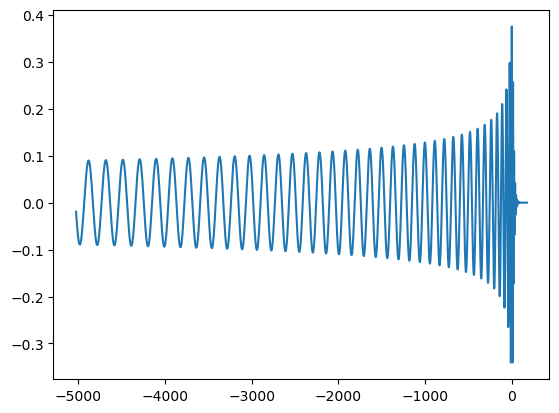

In [11]:
with open(os.path.join(Ccodesdir,"v5HM_BOB_generate_waveform_calibration.py"), "w") as output:
    output.write("import numpy as np\nfrom pygsl_lite import spline\n")
    output.write("from Dynamics.v5HM_BOB_optimized_initial_conditions import v5HM_BOB_optimized_initial_conditions\n")
    output.write("from Dynamics.v5HM_BOB_integrator_calibration import v5HM_BOB_integrator_calibration\n")
    output.write("from Dynamics.v5HM_optimized_auxiliary_functions import interpolate_modes_fast, get_waveforms_inspiral\n")
    output.write("from IMR.v5HM_BOB_apply_nqc_corrections import v5HM_BOB_apply_nqc_correction\n")
    output.write("from IMR.v5HM_BOB_compute_optimized_nqc_coefficients import v5HM_BOB_compute_optimized_nqc_coefficients\n")
    output.write("import qnm\n")
    output.write("from Radiation.v5HM_BOB_optimized_merger_ringdown import v5HM_BOB_optimized_merger_ringdown\n")
    output.write("def v5HM_BOB_generate_waveform_calibration(M,q,S1,S2,f,a6,dSO,Delta_t,dt,debug = False):\n")
    for line in list(open(os.path.join(Ccodesdir,"v5HM_BOB_Generate_Waveform_Calibration.txt"),"r")):
        output.write("    %s\n" % line.rstrip())
    output.write("    if not debug:\n        return t_IMR, h22_IMR\n    else:\n        return t_IMR, h22_IMR, h22_complex_BOB, h22_inspiral_plunge, interpolate_modes_fast(t_new, h22_inspiral_plunge_combined, dynamics), dynamics, tau")

import numpy as np
from IMR.v5HM_BOB_generate_waveform_calibration import v5HM_BOB_generate_waveform_calibration as v5HM

M = 50
f = 20
Msol = 4.925491025543575903411922162094833998e-6
Omega_0 = M*Msol*np.pi*f
q = 1.5
qs = "15"
chi1 = 0.02
chi2 = 0.01
chi1s = "02"
chi2s = "01"

m1 = q/(1. + q)
m2 = 1./(1. + q)
ap = m1*chi1 + m2*chi2
am = m1*chi1 - m2*chi2
nu = m1*m2

dSO = (
    -7.71251231383957 * am ** 3
    - 17.2294679794015 * am ** 2 * ap
    - 238.430383378296 * am ** 2 * nu
    + 69.5461667822545 * am ** 2
    - 10.5225438990315 * am * ap ** 2
    + 362.767393298729 * am * ap * nu
    - 85.8036338010274 * am * ap
    - 1254.66845939312 * am * nu ** 2
    + 472.431937787377 * am * nu
    - 39.742317057316 * am
    - 7.58458103577458 * ap ** 3
    - 42.7601129678844 * ap ** 2 * nu
    + 18.1783435552183 * ap ** 2
    - 201.905934468847 * ap * nu ** 2
    - 90.5790079104259 * ap * nu
    + 49.6299175121658 * ap
    + 478.546231305475 * nu ** 3
    + 679.521769948995 * nu ** 2
    - 177.334831768076 * nu
    - 37.6897780220529
)

para6 = np.array(
    [4.17877875e01, -3.02193382e03, 3.34144394e04, -1.69019140e05, 3.29523262e05]
)
a6 = para6[0] + para6[1] * nu + para6[2] * nu ** 2 + para6[3] * nu ** 3 + para6[4] * nu ** 4

pardTNS = np.array(
    [1.00513217e01, -5.96231800e01, -1.05687385e03, -9.79317619e03, 5.55652392e04]
)
Deltat_NS = nu ** (-1.0 / 5 + pardTNS[0] * nu) * (
    pardTNS[1] + pardTNS[2] * nu + pardTNS[3] * nu ** 2 + pardTNS[4] * nu ** 3
)

Deltat_S = nu ** (-1.0 / 5 + 0 * nu) * (
    8.39238879807543 * am ** 2 * ap
    - 16.9056858928167 * am ** 2 * nu
    + 7.23410583477034 * am ** 2
    + 6.38975598319936 * am * ap ** 2
    + 179.569824846781 * am * ap * nu
    - 40.6063653476775 * am * ap
    + 144.253395844761 * am * nu ** 2
    - 90.1929138487509 * am * nu
    + 14.2203101910927 * am
    - 6.78913884987037 * ap ** 4
    + 5.39962303470497 * ap ** 3
    - 132.224950777226 * ap ** 2 * nu
    + 49.8016443361381 * ap ** 2
    + 384.201018794943 * ap * nu ** 2
    - 141.253181790353 * ap * nu
    + 17.5710132409988 * ap
)

Deltat_v5HM = Deltat_NS + Deltat_S

t_IMR, h_IMR, q, z, b, n, tau = v5HM(M,q,chi1,chi2,f,a6,dSO,Deltat_v5HM,2.4627455127717882e-05, debug = True)

import matplotlib.pyplot as plt
print(t_IMR[-138:-135]/tau)
print(h_IMR[-138:-135])
print(tau)
plt.plot(t_IMR, np.real(h_IMR))